# Get Spatial data
This section is somewhat techincal. The specifics are not necessary to understand the analysis. 

In [24]:
# Import some packages
import warnings
import pandas as pd
import osmnx as ox 
import networkx as nx
import pandana as pa
import matplotlib.pyplot as plt
import utils.data_processing as dp
import utils.accessibility_analysis as aa
import geopandas

import seaborn as sns
import folium

# Some configs
warnings.filterwarnings('ignore')
ox.config(log_console=True, use_cache=True)
pd.set_option('display.max_columns', 200)
#%matplotlib inline

## Set bounding box

A bounding box of lattitude and longitude coordinates describes a rectangular geospatial region. For this report, I've chosen a bounding box that includes Wellington City and some of Lower Hutt. This selection is important since only the entities *within* the bounding box are used in the analysis. The visual tool [here](http://boundingbox.klokantech.com/) is useful for obtaining the bounding box coordinates from a user-defined rectangle on the map. 

A key technical point is that [bounding box conventions do vary](https://wiki.openstreetmap.org/wiki/Bounding_Box
):
- The general definition uses (min Longitude , min Latitude , max Longitude , max Latitude), or  (W, S, E, N) 
- Pandana and Overpass use (S, W, N, E).

![](assets/bounding_box_selection.png)


In [2]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.5813,-41.4552,175.0722,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

## Create Query
The following section creates a query to get fuel station data from Open Street Maps. The tags list can also be amended to get other amenities. The full list is [here](https://wiki.openstreetmap.org/wiki/Key:amenity). For example, we can easily get data for cafes and restaurants by adding these to the tags list.  

The Overpass API query is not very easy to read but the main components are: 
- The bounding box: the area where we want the search performed. 
- Data Primitives: ways, nodes, tags, relations.

The data primities of OSM have an intrinsic hierarchy with nodes being the root primitive. 
- Nodes: Single point with explicit [lat, lon] coordinates. Root primitive
- Ways: Collection of nodes that defines a polygon (e.g. a building) or polyline (e.g. a road). 
- Relations: Represent the relationship of existing nodes and ways
- Tags: Metadata stored as key-value pairs. 

The main primitives used in this report are nodes and tags. The nodes give the geolocation while we use the tags to filter specifically for fuel station nodes. More information about the entities of Open Street Maps can be found [here](https://en.wikipedia.org/wiki/OpenStreetMap#Operation). 

## Getting data from Overpass 
Getting data from Open Street Map is fairly simple via the Overpass API. All you need to do is construct the search query and reshape the result JSON into your data structure of choice. 
Given that pubs, alcohol shops and bars can be described as both nodes and ways, we need two queries to extract the data. Process ways as polygons and derive centroids; process nodes as POIs. Given that OSM contributors aren't choosing nodes or ways with preference, we need to include both in the analysis. 


In [3]:
# What types of entitities do we want to get? Currently restricted to amenities
tags = ['alcohol', 'pub', 'bar']
objects = ['node'] # like way, node, relation
entities = ['shop', 'amenity']
# Generate the query string
compactOverpassQLstring = dp.generate_overpass_query(tags, objects, osm_bbox, entities)

# Store nodes as df
osmdf_nodes = dp.get_osm_data(compactOverpassQLstring, osm_bbox)
alcohol_nodes = (osmdf_nodes[['id', 'lat', 'lon', 'name', 'amenity', 'type']]
                 .sort_values(['lat', 'lon'])
                 .reset_index()
                 .drop(columns='index'))
alcohol_nodes.head(5)

,id,lat,lon,name,amenity,type
0,4522166458,-41.328972,174.811298,Cook Strait Bar,bar,node
1,623879839,-41.325184,174.820872,The Strathmore Local,pub,node
2,625080280,-41.319506,174.794358,Bay 66,pub,node
3,627273501,-41.318117,174.794450,Kilbirnie Tavern,pub,node
4,627273500,-41.318011,174.794874,Corner Bar,pub,node


In [4]:
reload(dp)
# What types of entitities do we want to get? 
objects = ['way'] # like way, node, relation

# Generate the query string
compactOverpassQLstring = dp.generate_overpass_query(tags, objects, osm_bbox, entities)

# Store ways as df
osmdf_ways = dp.get_osm_data(compactOverpassQLstring, osm_bbox)
alcohol_ways = osmdf_ways[['id', 'lat', 'lon', 'name', 'amenity', 'type', 'nodes']]
alcohol_ways.head(5)

,id,lat,lon,name,amenity,type,nodes
0,62153738,NaN,NaN,Mac's Brewery,pub,way,"[775428527, 775428528, 775428657, 775428658, 2..."
1,133129214,NaN,NaN,Thistle Inn,bar,way,"[1464807182, 1464807184, 1464807179, 146480718..."
2,251574160,NaN,NaN,Southern Cross,bar,way,"[2577788320, 3003896629, 3003896628, 257778832..."
3,251574164,NaN,NaN,Havana Bar,bar,way,"[2577788337, 2577788338, 2577788339, 257778834..."
4,252076932,NaN,NaN,Laundry,bar,way,"[2581963186, 2581963187, 2581963188, 289473992..."


In [17]:
# Doesn't get the pubs, bars and shops without a name. Need to do a fillna()
# And check that the NAs are legit businesses
alcohol_ways_nodes = (osmdf_ways_clean
                      .merge(alcohol_ways[['id', 'amenity', 'name']]
                             .drop_duplicates(), left_on='way_id', right_on='id')
                      .groupby(['way_id', 'name', 'amenity', 'type'])
                      .agg({'lat': 'mean', 'lon': 'mean' })
                      .reset_index()
                      .rename(columns={'way_id': 'id'}))

In [18]:
alcohol_pois = pd.concat([alcohol_nodes, alcohol_ways_nodes])

In [19]:
map_alcohol = folium.Map(location=[-41.29, 174.8], zoom_start = 11)

for each in alcohol_pois.iterrows():
    folium.Marker(location = [each[1]['lat'],each[1]['lon']]).add_to(map_alcohol)
#    folium.Popup(each[1]['name']).add_to(map_alcohol)

map_alcohol

# Get parks data

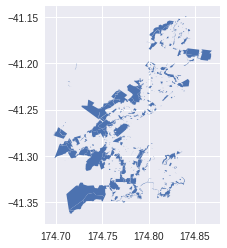

In [26]:
wcc_parks = geopandas.read_file('zip://./data/WCC_Parks_and_Reserves.zip')
wcc_parks.plot()

In [33]:
wcc_parks['centroid'] = wcc_parks.centroid

In [38]:
def getXY(pt):
    return (pt.x, pt.y)
x,y = [list(t) for t in zip(*map(getXY, wcc_parks['centroid']))]
park_pois = pd.DataFrame({'lat': x, 'lon': y})

In [91]:
import numpy as np
from shapely.geometry import Point

# Create Fake Data
df = pd.DataFrame({'lon': np.random.normal(174.77, 0.05, size=(1000)),
                   'lat': np.random.normal(-41.27, 0.07, size=(1000))})

# create Geometry series with lat / longitude
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]

df = df.drop(['lon', 'lat'], axis = 1)

# Create GeoDataFrame
points = geopandas.GeoDataFrame(df, crs=None, geometry=geometry)
points.head()

,geometry
0,POINT (174.7718683840959 -41.28688125951888)
1,POINT (174.7050679329131 -41.15979565387386)
2,POINT (174.7483965775859 -41.3382150510748)
3,POINT (174.7538303549211 -41.38365178389719)
4,POINT (174.7528959760159 -41.41191943217009)


In [106]:
intersecting_points = []

for i  in range(len(wcc_parks)):
    x = points[points.within(wcc_parks['geometry'].ix[i])]
    if len(x) > 0:
        intersecting_points.append(x)
        
intersecting_points = pd.concat(intersecting_points)

In [115]:
intersecting_points.head()
x,y = [list(t) for t in zip(*map(getXY, intersecting_points['geometry']))]
park_set_pois = pd.DataFrame({'lon': x, 'lat': y})

# Accessibility analysis
The above analyses only consider the fuel stations and quantify implicit interactions (via road distance) between them. But we get the real benefit of spatial analyses when we consider interactions between the fuel stations and other entities - from humans to other businesses. One type of interaction with general entities is accessibility. Simple accessibility analyses convert the base geography of the region into a point grid, and compute distances between every point and the POIS. 

Accessibility is a core analysis in urban planning. Some examples [here](https://www.slideshare.net/DimkaG/transitaccess-27460698). There are even tools which score regions with scores based on accessibility
e.g. [WalkScore](https://www.walkscore.com/). 

## Calculating accessibility
Here, we consider accessibility as the driving distance in meters from each grid point (also referred to as nodes) to the nearest POIS: a fuel station. To do a visual acessibility analysis we need to: 
- Break up the map into grid of points (I) 
- Calculate the distance from each point to the nth nearest POIS (II) 
- Visualise distance as a heatmap (III)

All the above steps are carried out by the Python package Pandana. Of the above steps, I has a few sub-steps. These are: 
- Download OSM data within the specified bounding box 
- Convert map to point grid. Remember, this is easy since all OSM streets and roads are *ways* which are simply a collection of nodes / points. 
- Store points data in a convenient data structure: a Pandas dataframe 
- Filter out poorly connected points

In [108]:
# Set some parameters for accessibility analysis
n = 1 # nth closest nodes to fuel station. n = 1 means the closest.
distance = 5000.0 # distance bound for accessibility calculation; impedance limit.
num_pois = 10

# Plotting parameters
bbox_aspect_ratio = (osm_bbox[2] - osm_bbox[0]) / (osm_bbox[3] - osm_bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}
#plot_kwargs = {'s':5, 
#               'alpha':0.9, 
#               'cmap':'viridis_r', 
#               'edgecolor':'none'}

bmap_kwargs={'epsg':'2193','resolution':'f'}
plot_kwargs={'cmap':'viridis_r','s':4,'edgecolor':'none'}

In [109]:
# Generate accessibility network
network = aa.get_pandana_network(osm_bbox, impedance=distance)
alco_accessibility = aa.get_accessibility(network, alcohol_pois, distance=distance, num_pois=num_pois)


In [116]:
park_accessibility = aa.get_accessibility(network, park_set_pois, distance=distance, num_pois=num_pois)

## Accessibility to alcohol

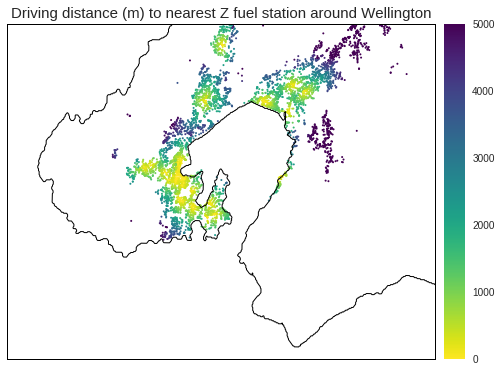

In [110]:
# Plot driving accessibility for Z stations
aa.plot_accessibility(network, alco_accessibility[n], osm_bbox, 
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)

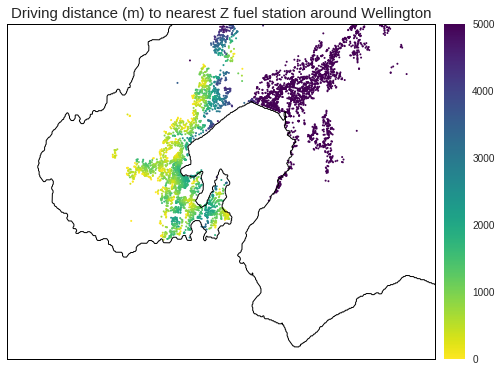

In [117]:
# Plot driving accessibility for Z stations
aa.plot_accessibility(network, park_accessibility[n], osm_bbox, 
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)

In [114]:
park_set_pois

,lat,lon
0,174.860833,-41.187855
1,174.782930,-41.339567
2,174.703478,-41.273994
3,174.698284,-41.276068
4,174.754874,-41.274888
5,174.749657,-41.302973
6,174.759475,-41.299670
7,174.757451,-41.287784
8,174.831678,-41.329999
9,174.793326,-41.294907


## Differential accessbility: playgrounds vs. alcohol

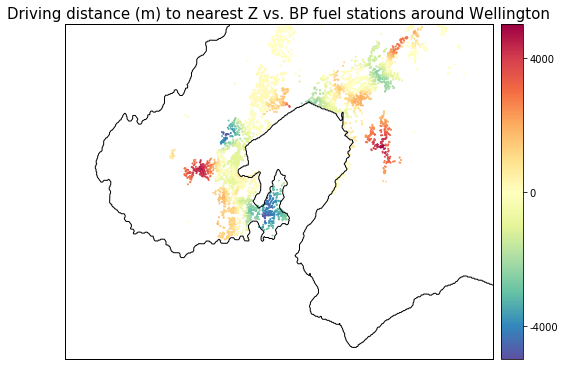

In [84]:
# Plotting parameters
diff_kwargs = plot_kwargs.copy()
diff_kwargs['cmap'] = 'Spectral_r'
bmap_kwargs={'epsg':'2193','resolution':'f'}
cbar_kwargs = {'location': 'right', 
               'format': '%d', 
               'label':'',
               'ticks': [-4000, 0, 4000]}

# Plot differential coverage
diff_accessibility = z_accessibility[1] - bp_accessibility[1]
bmap = na.plot_accessibility(network, diff_accessibility, osm_bbox, 
                      amenity_type="Z vs. BP fuel stations",
                      fig_kwargs=fig_kwargs, plot_kwargs=diff_kwargs, 
                      bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)


The convenience of the common accessibility nodes can help us approximate an average accessibility to a Z / BP station for the Wellington region. The histograms plot the distance to the nearest Z / BP station. The mean and median show two quite interesting points:
- There are more nodes that are more than 5km from a Z station. These "inaccessible" nodes increase the mean accessibility to a Z station for the region. The difference in the mean accessibility of Z and BP are fairly close.  Z stations are only closer by 100 m. 
- If the inaccessible nodes are not considered as strongly (i.e. using the median), Z stations are more accessible by 200m. 

While Z does better for the covered regions, the regions that aren't covered by Z reduce the average accessibility.  

In [27]:
# Put accessibility data together
nearest_z = z_accessibility[1].reset_index(name='distance')
nearest_bp = bp_accessibility[1].reset_index(name='distance')
nearest_z['brand'] = 'Z'
nearest_bp['brand'] = 'BP'

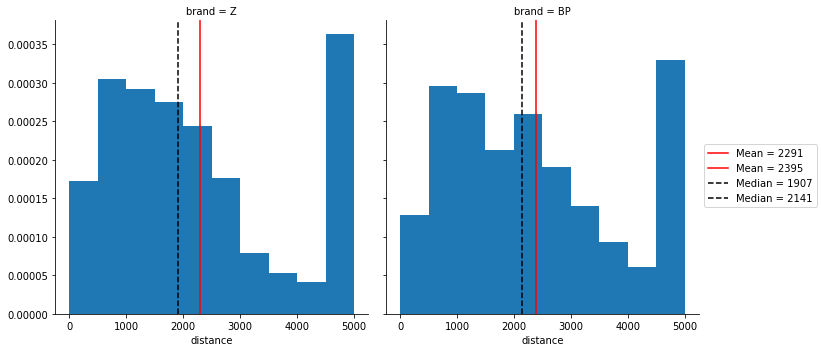

In [28]:
# Plot Z and BP accessibility together
nearest_station = pd.concat([nearest_z, nearest_bp])
g = sns.FacetGrid(col='brand', data=nearest_station, size=5)
g.map(plt.hist, 'distance', normed=True)
g.map(na.vertical_average_lines, 'distance')
g.add_legend()

We can explicitly only plot the nodes that fall within the accessible areas. Z accessibility is 200 m better than BP for both mean and median averages. The previous plot also showed some indication of a bimodal distribution in accessibility for BP. Increasing the number of bins shows that there is *likely* a bimodal accessibility distribution for BP (similar result in an [earlier section](#Competitor-Analysis)). But, we'd need to think a little deeper as why this might be the case before .  

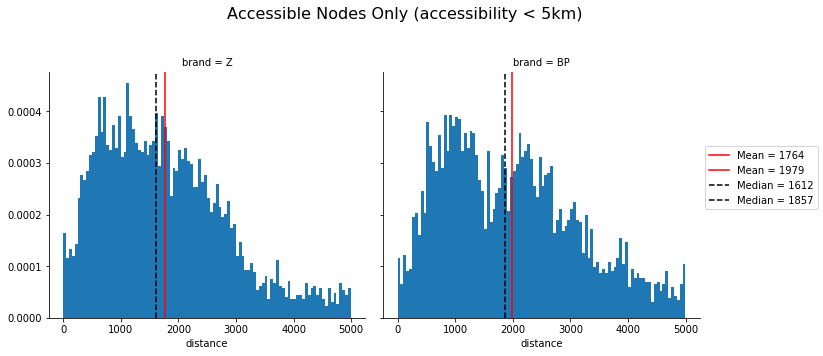

In [29]:
# Plot Z and BP accessibility together. Only nodes within accesibility calculation limit
nearest_station = pd.concat([nearest_z, nearest_bp])
g = sns.FacetGrid(col='brand', data=nearest_station.query('distance < 5000.'), size=5)
g.map(plt.hist, 'distance', normed=True, bins=100)
g.map(na.vertical_average_lines, 'distance')
g.add_legend()
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Accessible Nodes Only (accessibility < 5km)', fontsize=16);

# Conclusions
The key business question to be answered in this report was: 
> *Does Z have better coverage than their competitor(s) in Wellington? If so, how?*

Through a variety of different spatial analyses, we can quantify some aspects of this question:
- Z stations are closer together on average, compared to BP.
- Z stations in Wellington City are closely-knit. A Z station in Wellington City has 6.5 Z stations within 10 km. That's 2 more stations than the average for the Lower Hutt sub-network (component).    
- BP have more physical stations in Lower Hutt. 
- Average accessibility to Z stations is better than BP stations. 
- Both Z and BP vie for coverage in the Wellington region - doing well in some areas and poorly in others: 
    - Z has exclusive coverage in the Miramar Peninsula and North Western suburbs (Ngaio, Crofton Downs). Petone and the Hutt along the main Hutt Road / High Street artery of Lower Hutt are also better served by Z.
    - BP exclusively covers Wainuiomata and Karori. Parts of the Southern suburbs (like Island Bay) are also better covered by BP. 

Given the above findings, we can tentatively answer the business question
> Z stations have better coverage in Wellington compared to BP. 

However, this tentative conclusion needs more work to become a substantive one. Suggestions in the following section. 

# Future Work
Some immediate follow up work can include:
- A more complete analysis. Since Z is not the only brand of the *Z entity*, we need to include Caltex Stations as well. 
- Combining population density with accessibility. Currently, accessibility analysis considers every node to contain the same number of people. This is clearly untrue. A better understanding of the weaknesses in Z's coverage would need to know which high population density nodes have poor access to Z stations.  
- Better visualisation of the Pandana heatmaps.

Useful but not as neatly specified work includes:
- Understanding the distribution of available services.
- Statisical modeling: 
    - Clustering stations by available services and local geography (e.g. suburban station near many other amenities, isolated suburban station etc).
    - Using spatial flow models (e.g. Retail Model) to predict patronage per fuel station in region; and changes to patronage given poaching by nearby competition. Can consider this a 'No Loyalty' baseline. Useful for comparing with actual patronage data. 